<h1><span style="color:steelblue"> Book Recommendation System </span></h1>

In [1]:
import warnings
import phik
import string
import nltk
import pickle
import os
import re
import sqlite3
import hnswlib
import hashlib
import requests


import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader as gdl

from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import KeyedVectors
from sklearn.model_selection import GridSearchCV as skGridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score
from surprise import Dataset, Reader, NMF, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from io import StringIO

%matplotlib inline

In [2]:
#Displaying max columns and rows:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Suppressing FutureWarning:
warnings.simplefilter(action='ignore', category=FutureWarning)

## <span style="color:steelblue"> Data Preprocessing and EDA</span>

<em><span style="color:lightsteelblue"> Extract data</span></em>

In [3]:
books_url = "https://raw.githubusercontent.com/malcolmosh/goodbooks-10k-extended/refs/heads/master/books_enriched.csv"
ratings_url = "https://raw.githubusercontent.com/malcolmosh/goodbooks-10k-extended/refs/heads/master/ratings.csv"

In [4]:
def download_csv(url):
    response = requests.get(url)
    response.raise_for_status()
    return pd.read_csv(StringIO(response.text))

In [5]:
books = download_csv(books_url)
ratings = download_csv(ratings_url)

<div class="alert alert-block alert-info">
    
- This dataset contains six million ratings for ten thousand most popular (with most ratings) books.<br><br>
- Each book may have many editions. goodreads_book_id and best_book_id generally point to the most popular edition of a given book, while goodreads work_id refers to the book in the abstract sense.<br><br>
- Note that book_id in ratings.csv maps to work_id, not to goodreads_book_id, meaning that ratings for different editions are aggregated.

<em><span style="color:lightsteelblue"> View ratings data </span></em>

In [6]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [7]:
num_ratings = ratings['rating'].count()

print(f'There are {num_ratings:,} total ratings.')

There are 5,976,479 total ratings.


In [8]:
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()

print(f'The ratings range from {min_rating} to {max_rating}.')

The ratings range from 1 to 5.


In [9]:
num_users = ratings['user_id'].nunique()

print(f'There are {num_users:,} users in total.')

There are 53,424 users in total.


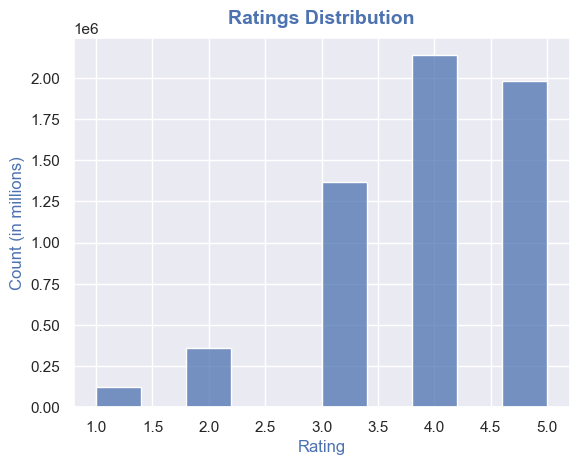

In [10]:
sns.set_theme()
sns.histplot(x=ratings['rating'], bins=10)
plt.xlabel('Rating', fontsize=12, c='#4c72b0')
plt.ylabel('Count (in millions)', fontsize=12, c='#4c72b0')
plt.title('Ratings Distribution', size=14,\
          pad=10, fontweight='bold', color='#4c72b0')

plt.show()

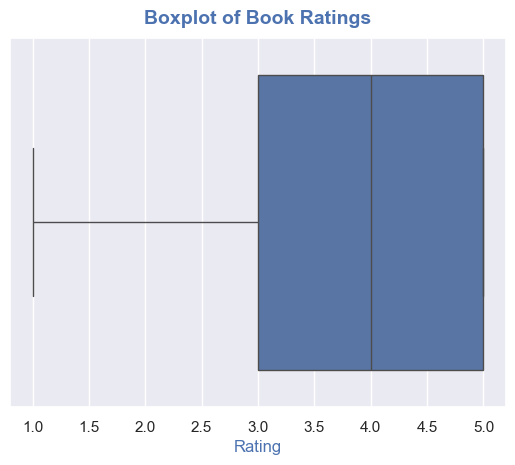

In [11]:
sns.boxplot(x=ratings['rating'], orient='h')
plt.xlabel('Rating', fontsize=12, c='#4c72b0')
plt.title('Boxplot of Book Ratings', size=14, pad=10, fontweight='bold', color='#4c72b0')

plt.show()

<em><span style="color:lightsteelblue"> View books data</span></em>

In [12]:
books.head()

,Unnamed: 0,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,isbn,isbn13,language_code,original_publication_year,original_title,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2
0,0,0,['Suzanne Collins'],4.34,2767052,1,272,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,439023483,9.780439e+12,eng,2008.0,The Hunger Games,374.0,09/14/08,66715,127936,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254,['Suzanne Collins']
1,1,1,"['J.K. Rowling', 'Mary GrandPré']",4.44,3,2,491,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,439554934,9.780440e+12,eng,1997.0,Harry Potter and the Philosopher's Stone,309.0,11/01/03,75504,101676,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867,"['J.K. Rowling', 'Mary GrandPré']"
2,2,2,['Stephenie Meyer'],3.57,41865,3,226,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,316015849,9.780316e+12,eng,2005.0,Twilight,501.0,09/06/06,456191,436802,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009,['Stephenie Meyer']
3,3,3,['Harper Lee'],4.25,2657,4,487,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,61120081,9.780061e+12,eng,1960.0,To Kill a Mockingbird,324.0,05/23/06,60427,117415,446835,1001952,1714267,3198671,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,3340896,72586,['Harper Lee']
4,4,4,['F. Scott Fitzgerald'],3.89,4671,5,1356,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,743273567,9.780743e+12,eng,1925.0,The Great Gatsby,200.0,09/28/04,86236,197621,606158,936012,947718,2683664,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992,['F. Scott Fitzgerald']


In [13]:
top_rated = books[books['average_rating'] >= 4.5]
top_rated_count = top_rated['work_id'].count()
print(f'There are {top_rated_count} books with an average rating of 4.5 or greater.')

There are 144 books with an average rating of 4.5 or greater.


In [14]:
mid_rated = books[(books['average_rating'] > 2.5) & (books['average_rating'] < 4.5)]
mid_rated_count = mid_rated['work_id'].count()
print(f'There are {mid_rated_count:,} books with an average rating greater than 2.5 but less than 4.5.')

There are 9,855 books with an average rating greater than 2.5 but less than 4.5.


In [15]:
low_rated = books[books['average_rating'] <= 2.5]
low_rated_count = low_rated['work_id'].count()
print(f'There is {low_rated_count} book with an average rating of 2.5 or less.')

There is 1 book with an average rating of 2.5 or less.


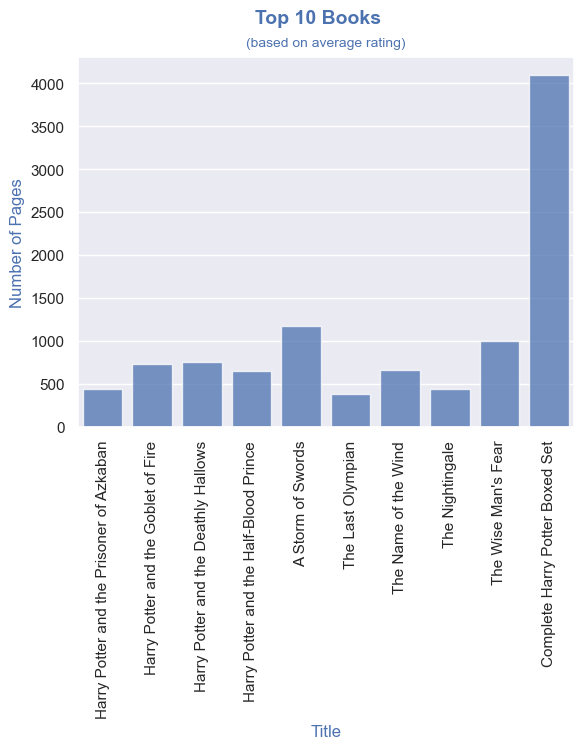

In [16]:
top_10_books = top_rated[:10]

sns.barplot(data=top_10_books,
            x='original_title', y='pages', 
            color='#4c72b0', alpha=.75, saturation=100)
plt.xlabel('Title', fontsize=12, c='#4c72b0')
plt.xticks(rotation=90)
plt.ylabel('Number of Pages', fontsize=12, c='#4c72b0')
plt.suptitle('Top 10 Books', size=14, fontweight='bold', color='#4c72b0')
plt.title('(based on average rating)', size=10, pad=8, c='#4c72b0')

plt.show()

<em><span style="color:lightsteelblue"> Compare books in ratings df to books in books df  </span></em>

In [17]:
# 'book_id' in ratings df correspond to 'work_id' in books df.

ratings.rename(columns={'book_id':'work_id'}, inplace=True)

In [18]:
print(ratings['work_id'].nunique())
print(books['work_id'].nunique())

10000
10000


In [19]:
matched_ids = ratings[ratings['work_id'].isin(books['work_id'])]
matched_ids_count = matched_ids['work_id'].nunique()

print(f'There are {matched_ids_count} books in the books df that have been rated.')

There are 176 books in the books df that have been rated.


In [20]:
unmatched_ids = ratings[~ratings['work_id'].isin(books['work_id'])]
unmatched_ids_count = unmatched_ids['work_id'].nunique()

print(f'There are {unmatched_ids_count} books from the books df that have not been rated.')
print(f'There are {unmatched_ids_count} books that have been rated but do not exist in the books df.')

There are 9824 books from the books df that have not been rated.
There are 9824 books that have been rated but do not exist in the books df.


<em><span style="color:lightsteelblue"> Remove books that don't exist in books df from ratings df  </span></em>

In [21]:
ratings['work_id'] = matched_ids['work_id']

In [22]:
ratings.head()

,user_id,work_id,rating
0,1,NaN,5
1,2,NaN,4
2,2,NaN,5
3,2,NaN,5
4,2,NaN,3


In [23]:
ratings.dropna(inplace=True)

In [24]:
ratings['work_id'] = ratings['work_id'].astype('int64')

In [25]:
ratings.head()

,user_id,work_id,rating
60,8,362,5
84,4,87,5
169,11,574,3
181,11,115,4
209,15,87,5


In [26]:
print(ratings['work_id'].dtype)
print(books['work_id'].dtype)

int64
int64


In [27]:
print(ratings['work_id'].nunique())
print(books['work_id'].nunique())

176
10000


<div class="alert alert-block alert-info">
    
- The ratings df suggest that only 176 books from the books df have been rated. The other 9,824 rated books found in the ratings df do not exist in the books df. 
<br><br>
- The average rating in the books df indicates that all 10,000 books in the books df have been rated.
<br><br>
- average_rating in the books df may not reflect the same ratings as the ratings df.

<em><span style="color:lightsteelblue"> Merge books df with ratings df </span></em>

In [28]:
goodbooks = books.merge(ratings, how='left', on='work_id')

In [29]:
goodbooks.head()

,Unnamed: 0,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,isbn,isbn13,language_code,original_publication_year,original_title,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2,user_id,rating
0,0,0,['Suzanne Collins'],4.34,2767052,1,272,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,439023483,9.780439e+12,eng,2008.0,The Hunger Games,374.0,09/14/08,66715,127936,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254,['Suzanne Collins'],NaN,NaN
1,1,1,"['J.K. Rowling', 'Mary GrandPré']",4.44,3,2,491,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,439554934,9.780440e+12,eng,1997.0,Harry Potter and the Philosopher's Stone,309.0,11/01/03,75504,101676,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867,"['J.K. Rowling', 'Mary GrandPré']",NaN,NaN
2,2,2,['Stephenie Meyer'],3.57,41865,3,226,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,316015849,9.780316e+12,eng,2005.0,Twilight,501.0,09/06/06,456191,436802,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009,['Stephenie Meyer'],NaN,NaN
3,3,3,['Harper Lee'],4.25,2657,4,487,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,61120081,9.780061e+12,eng,1960.0,To Kill a Mockingbird,324.0,05/23/06,60427,117415,446835,1001952,1714267,3198671,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,3340896,72586,['Harper Lee'],NaN,NaN
4,4,4,['F. Scott Fitzgerald'],3.89,4671,5,1356,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,743273567,9.780743e+12,eng,1925.0,The Great Gatsby,200.0,09/28/04,86236,197621,606158,936012,947718,2683664,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992,['F. Scott Fitzgerald'],NaN,NaN


<em><span style="color:lightsteelblue">Handle missing values in [user_id] and [rating]</span></em>

In [30]:
goodbooks['user_id'].fillna(0, inplace=True)
goodbooks['rating'].fillna(0, inplace=True)

In [31]:
goodbooks.head()

,Unnamed: 0,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,isbn,isbn13,language_code,original_publication_year,original_title,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2,user_id,rating
0,0,0,['Suzanne Collins'],4.34,2767052,1,272,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,439023483,9.780439e+12,eng,2008.0,The Hunger Games,374.0,09/14/08,66715,127936,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254,['Suzanne Collins'],0.0,0.0
1,1,1,"['J.K. Rowling', 'Mary GrandPré']",4.44,3,2,491,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,439554934,9.780440e+12,eng,1997.0,Harry Potter and the Philosopher's Stone,309.0,11/01/03,75504,101676,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867,"['J.K. Rowling', 'Mary GrandPré']",0.0,0.0
2,2,2,['Stephenie Meyer'],3.57,41865,3,226,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,316015849,9.780316e+12,eng,2005.0,Twilight,501.0,09/06/06,456191,436802,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009,['Stephenie Meyer'],0.0,0.0
3,3,3,['Harper Lee'],4.25,2657,4,487,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,61120081,9.780061e+12,eng,1960.0,To Kill a Mockingbird,324.0,05/23/06,60427,117415,446835,1001952,1714267,3198671,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,3340896,72586,['Harper Lee'],0.0,0.0
4,4,4,['F. Scott Fitzgerald'],3.89,4671,5,1356,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,743273567,9.780743e+12,eng,1925.0,The Great Gatsby,200.0,09/28/04,86236,197621,606158,936012,947718,2683664,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992,['F. Scott Fitzgerald'],0.0,0.0


In [32]:
goodbooks['user_id'] = goodbooks['user_id'].astype('int64')
goodbooks['rating'] = goodbooks['rating'].astype('int64')

In [33]:
print(goodbooks['user_id'].dtypes)
print(goodbooks['rating'].dtypes)

int64
int64


In [34]:
goodbooks.sample(5)

,Unnamed: 0,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,isbn,isbn13,language_code,original_publication_year,original_title,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2,user_id,rating
2680,292,292,['Wilson Rawls'],4.04,10365,321,69,"A loving threesome, they ranged the dark hills...","['classics', 'fiction', 'young-adult', 'histor...",10365,https://images.gr-assets.com/books/1166154337m...,375806814,9.780376e+12,eng,1961.0,Where the Red Fern Grows,272.0,05/09/00,6585,15232,53560,89699,115103,268548,https://images.gr-assets.com/books/1166154337s...,Where the Red Fern Grows,115,280179,8725,['Wilson Rawls'],1554,5
19916,1395,1395,['James Ellroy'],3.75,21704,1485,93,"On January 15, 1947, the torture-ravished body...","['mystery', 'fiction', 'crime', 'historical-fi...",21704,https://images.gr-assets.com/books/1387048173m...,446698873,9.780447e+12,eng,1987.0,The Black Dahlia,348.0,August 16th 2006,1999,4999,17641,23340,17425,61412,https://images.gr-assets.com/books/1387048173s...,"The Black Dahlia (L.A. Quartet, #1)",434,65404,1944,['James Ellroy'],50565,3
138944,9689,9082,['[Nick Hornby]'],3.56,4261,9083,42,“All I have to say about these songs is that I...,"['music', 'nonfiction', 'fiction', 'memoir', '...",4261,https://images.gr-assets.com/books/1417984618m...,1573223565,9.781573e+12,eng,2003.0,31 Songs,207.0,"('10', '7', '2003')",363,1032,3811,3744,2135,8999,https://images.gr-assets.com/books/1417984618s...,Songbook,7951,11085,485,['[Nick Hornby]'],25505,3
93846,5840,5840,['Diane Duane'],3.80,116563,6683,30,Nita Callahan is at the end of her rope becaus...,"['fantasy', 'young-adult', 'fiction', 'science...",116563,https://images.gr-assets.com/books/1328877065m...,152047387,9.780152e+12,eng,1983.0,So You Want to Be a Wizard,323.0,July 1st 2003,798,1791,5478,7247,6967,20408,https://images.gr-assets.com/books/1328877065s...,"So You Want to Be a Wizard (Young Wizards, #1)",3464,22281,971,['Diane Duane'],420,3
77425,4807,4807,"['Milan Kundera', 'Suzanne Rappaport']",3.86,26101,5374,113,Laughable Loves is a collection of stories tha...,"['fiction', 'classics', 'contemporary', 'philo...",26101,https://s.gr-assets.com/assets/nophoto/book/11...,571206921,9.780571e+12,eng,1970.0,Směšné lásky,287.0,August 21st 2000,179,838,4631,7271,4489,12984,https://s.gr-assets.com/assets/nophoto/book/50...,Laughable Loves,3838,17408,781,"['Milan Kundera', 'Suzanne Rappaport']",51997,3


In [35]:
goodbooks.shape

(140010, 32)

<em><span style="color:lightsteelblue">View missing values</span></em>

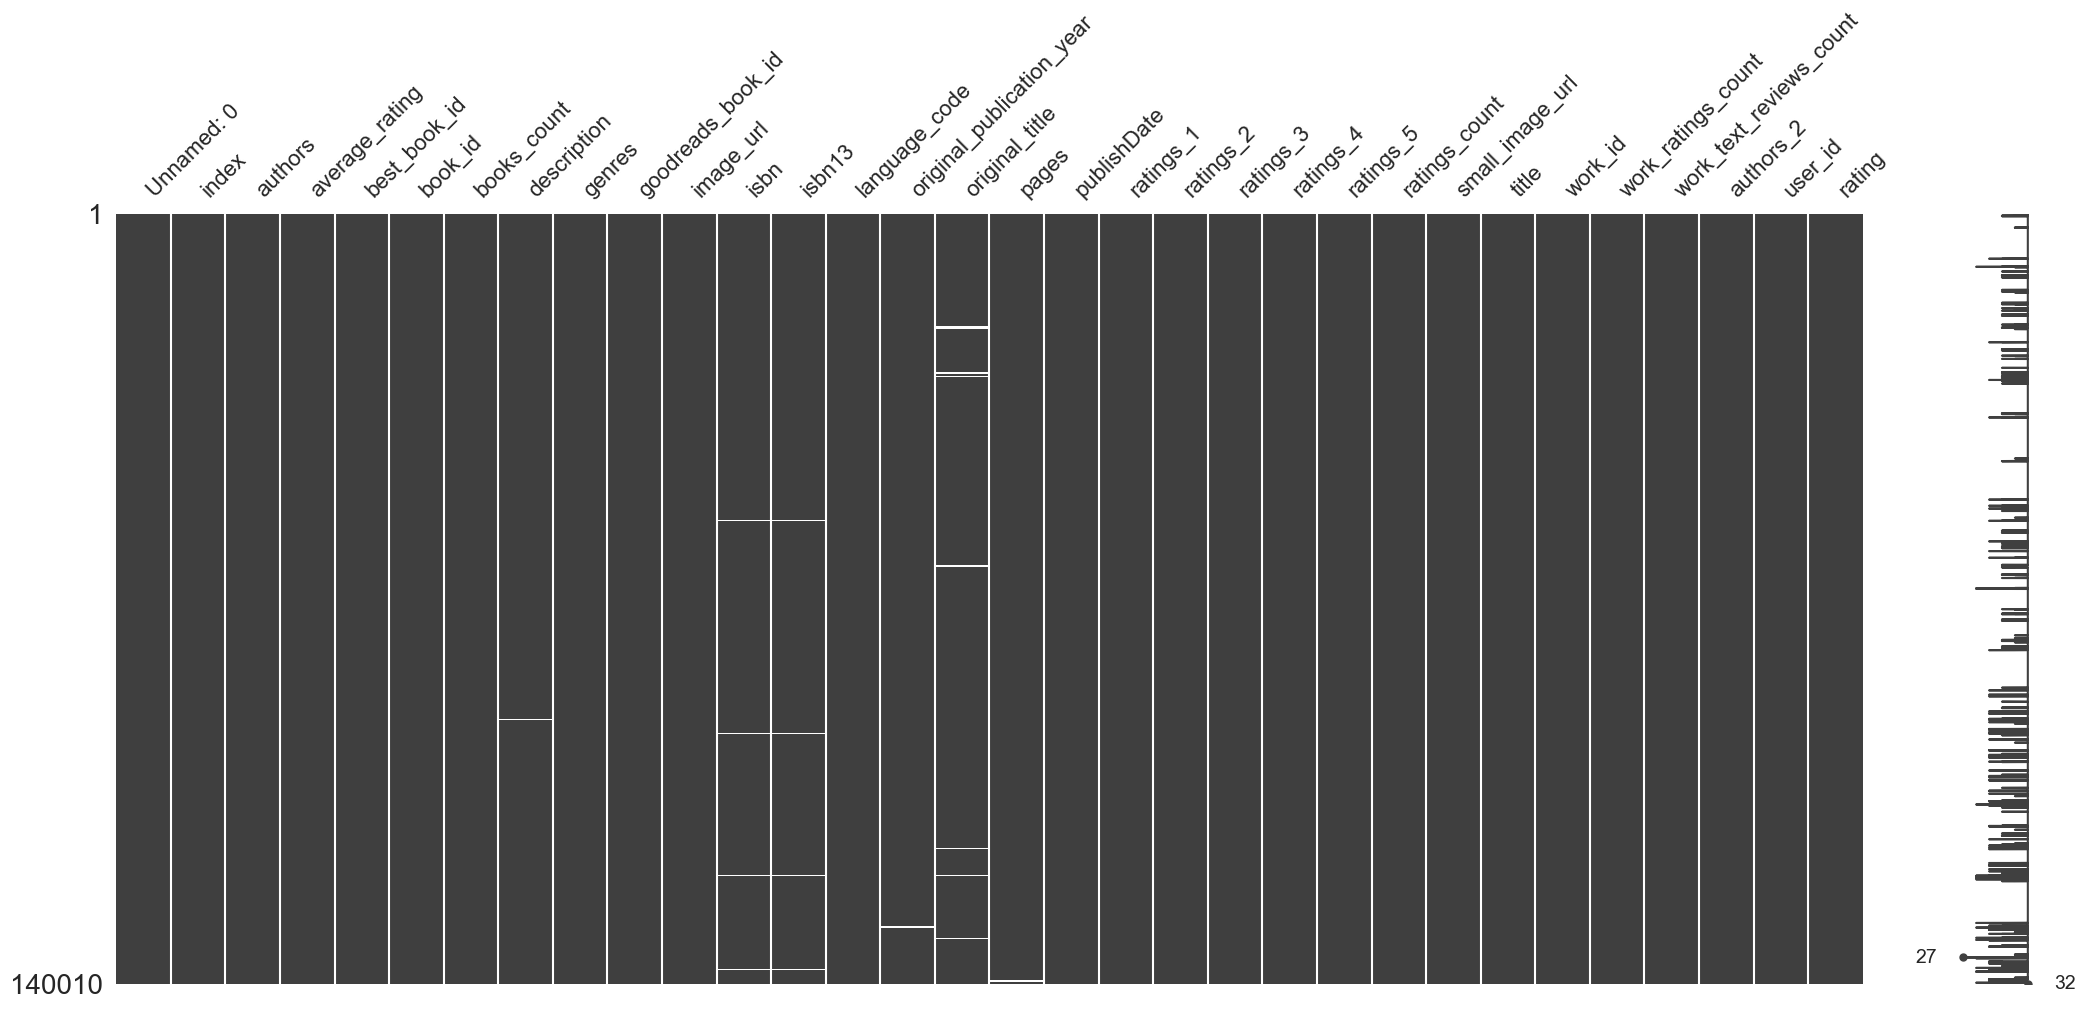

In [36]:
msno.matrix(goodbooks)
plt.show()

<em><span style="color:lightsteelblue">Confirm duplicate column</span></em>

In [37]:
author_df = goodbooks[['authors', 'authors_2']]
author_df.sample(5)

,authors,authors_2
73897,['Roger Zelazny'],['Roger Zelazny']
37632,['Nelson DeMille'],['Nelson DeMille']
81123,"['Isabel Allende', 'Margaret Sayers Peden']","['Isabel Allende', 'Margaret Sayers Peden']"
34193,['Patricia Schultz'],['Patricia Schultz']
40655,['Barbara Taylor Bradford'],['Barbara Taylor Bradford']


In [38]:
unmatched_authors = author_df[~author_df['authors'].isin(author_df['authors_2'])]
unmatched_authors['authors'].nunique()

0

<em><span style="color:lightsteelblue">Drop redundant columns and columns containing missing values</span></em>

In [39]:
goodbooks.drop(columns=['Unnamed: 0', 'index', 'average_rating', 
                        'best_book_id', 'isbn', 'isbn13',
                        'original_publication_year', 'original_title',
                        'pages','publishDate', 'authors_2'], inplace=True)

In [40]:
goodbooks.shape

(140010, 21)

<em><span style="color:lightsteelblue">Handle missing values in [description]</span></em>

In [41]:
goodbooks['description'].isna().sum()

209

In [42]:
goodbooks.dropna(subset=['description'], inplace=True)

In [43]:
goodbooks['description'].isna().sum()

0

In [44]:
goodbooks.shape

(139801, 21)

<em><span style="color:lightsteelblue">Generate profile report </span></em>

In [45]:
goodbooks_report = ProfileReport(goodbooks.sample(10000, random_state=42),
                                vars={'num':{'low_categorical_threshold':0}},
                                correlations={'auto': {'calculate':False}})
# goodbooks_report.to_file('goodbooks_report.html')

<em><span style="color:lightsteelblue">Drop imbalanced column</span></em>

In [46]:
goodbooks.drop(columns=['language_code'], inplace=True)

In [47]:
goodbooks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139801 entries, 0 to 140009
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   authors                  139801 non-null  object
 1   book_id                  139801 non-null  int64 
 2   books_count              139801 non-null  int64 
 3   description              139801 non-null  object
 4   genres                   139801 non-null  object
 5   goodreads_book_id        139801 non-null  int64 
 6   image_url                139801 non-null  object
 7   ratings_1                139801 non-null  int64 
 8   ratings_2                139801 non-null  int64 
 9   ratings_3                139801 non-null  int64 
 10  ratings_4                139801 non-null  int64 
 11  ratings_5                139801 non-null  int64 
 12  ratings_count            139801 non-null  int64 
 13  small_image_url          139801 non-null  object
 14  title               

<em><span style="color:lightsteelblue">Clean [title]</span></em>

In [48]:
goodbooks['title'] = goodbooks['title'].str.replace(r'\s*\(.*?\)\s*', ' ', regex=True)
goodbooks['title'] = goodbooks['title'].str.strip()

In [49]:
goodbooks['title'][:3]

0                         The Hunger Games
1    Harry Potter and the Sorcerer's Stone
2                                 Twilight
Name: title, dtype: object

<em><span style="color:lightsteelblue">Remove [image_url] duds</span></em>

In [50]:
goodbooks['image_url'].value_counts().sum()

139801

In [51]:
nophoto_url = goodbooks.loc[goodbooks['title'] == 'Rabbit Redux']
print(nophoto_url)

                authors  book_id  books_count  \
111287  ['John Updike']     8625           52   

                                              description  \
111287  In this sequel to Rabbit, Run, John Updike res...   

                                                   genres  goodreads_book_id  \
111287  ['fiction', 'classics', 'contemporary', 'roman...              46917   

                                                image_url  ratings_1  \
111287  https://s.gr-assets.com/assets/nophoto/book/11...        269   

        ratings_2  ratings_3  ratings_4  ratings_5  ratings_count  \
111287        798       3052       4564       3044          11051   

                                          small_image_url         title  \
111287  https://s.gr-assets.com/assets/nophoto/book/50...  Rabbit Redux   

        work_id  work_ratings_count  work_text_reviews_count  user_id  rating  
111287   864749               11727                      604        0       0  


In [52]:
goodbooks['image_url'] = goodbooks['image_url'].str.strip()

In [53]:
pattern = 'https://s.gr-assets.com/assets/nophoto/book/'
goodbooks = goodbooks[~goodbooks['image_url'].str.contains(pattern, case=False, na=False)]

In [54]:
goodbooks['image_url'].value_counts().sum()

73185

In [55]:
goodbooks.shape

(73185, 20)

<em><span style="color:lightsteelblue">Clean [authors]</span></em>

In [56]:
goodbooks['authors'] = goodbooks['authors'].str.replace(r"[\[\]'']", '', regex=True).str.strip()
goodbooks['authors'] = goodbooks['authors'].apply((lambda x: x.split(',')[0].split(';')[0].strip()))

In [57]:
goodbooks['authors'][:3]

0    Suzanne Collins
1       J.K. Rowling
2    Stephenie Meyer
Name: authors, dtype: object

<em><span style="color:lightsteelblue">(add. EDA)</span></em>

In [58]:
authors = goodbooks['authors'].value_counts()
top_10_authors = authors[:10]
top_10_authors

Barbara Taylor Bradford    6466
Wilson Rawls               5615
Neil Strauss               3560
Max Brooks                 3225
Frank Herbert              2312
Connie Willis              2264
Joe Haldeman               2196
Tim Burton                 1782
David Sedaris              1601
Susan Cooper               1559
Name: authors, dtype: int64

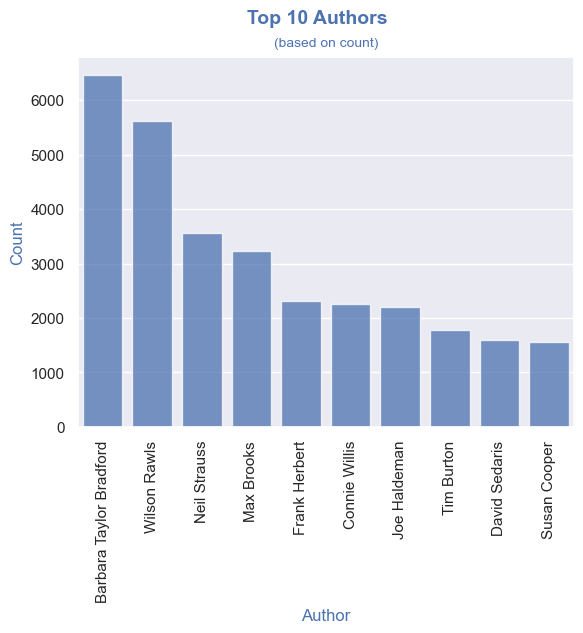

In [59]:
sns.barplot(data=top_10_authors, alpha=.75, saturation=100)
plt.xlabel('Author', fontsize=12, c='#4c72b0')
plt.xticks(rotation=90)
plt.ylabel('Count', fontsize=12, c='#4c72b0')
plt.suptitle('Top 10 Authors', size=14, fontweight='bold', color='#4c72b0')
plt.title('(based on count)', size=10, pad=8, c='#4c72b0')

plt.show()

## <span style="color:steelblue"> Feature Engineering </span>

<em><span style="color:lightsteelblue">Select features using phik correlations and p-values</span></em>

In [60]:
goodbooks_phik = goodbooks.copy()
interval_columns = ['book_id', 'books_count', 'goodreads_book_id',
                    'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4',
                    'ratings_5', 'ratings_count','work_id', 'work_ratings_count',
                    'work_text_reviews_count','user_id']

for c in goodbooks_phik.columns:
    if c not in interval_columns:
        goodbooks_phik[c] = goodbooks_phik[c].astype('category')

In [61]:
phik_correlations = []
phik_significances = []
columns = goodbooks_phik.columns
y = goodbooks_phik['rating']

for c in columns:
    x = goodbooks_phik[c]
    if c in interval_columns:
        phik_correlations.append(phik.phik_from_array(x,y,[c]))
        phik_significances.append(phik.significance.significance_from_array(x,y,[c])[0])
    else:
        phik_correlations.append(phik.phik_from_array(x,y))
        phik_significances.append(phik.significance.significance_from_array(x,y)[0])

C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 2831. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 2831. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 6563. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 6563. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\Users\xanaa\anaconda3\Lib\site-packages\phik\data_quality.py:119: UserWarning: The nu

In [62]:
phik_df = pd.DataFrame({'phik': phik_correlations, 'p-value': phik_significances},
                      index=columns)
phik_df.sort_values(by='phik', ascending=False, inplace=True)

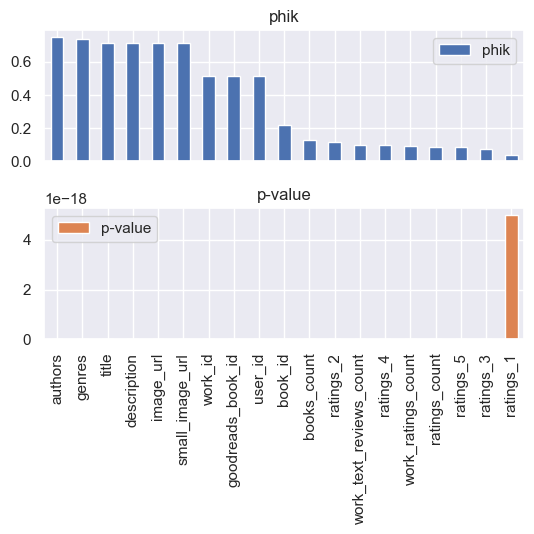

In [63]:
phik_df.iloc[1:].plot.bar(subplots=True, figsize=(5.5,5.5))
plt.tight_layout()
plt.show()

In [64]:
goodbooks.drop(columns=['book_id', 'ratings_2', 'books_count', 'ratings_4',
                        'work_text_reviews_count', 'work_ratings_count', 
                        'ratings_count', 'ratings_5', 'ratings_3',
                        'ratings_1'], inplace=True)

In [65]:
goodbooks.shape

(73185, 10)

In [66]:
goodbooks.head(3)

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating
0,Suzanne Collins,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games,2792775,0,0
1,J.K. Rowling,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone,4640799,0,0
2,Stephenie Meyer,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,Twilight,3212258,0,0


<em><span style="color:lightsteelblue">Normalize [description]</span></em>

In [67]:
goodbooks['description'][:3]

0    WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...
1    Harry Potter's life is miserable. His parents ...
2    About three things I was absolutely positive.\...
Name: description, dtype: object

In [68]:
goodbooks['description'] = goodbooks['description'].str.lower().str.capitalize()

In [69]:
goodbooks['description'][:3]

0    Winning means fame and fortune.losing means ce...
1    Harry potter's life is miserable. his parents ...
2    About three things i was absolutely positive.\...
Name: description, dtype: object

In [70]:
def normalize_description(desc):
    desc = re.sub(r'\.([a-z])', r'. \1', desc)
    sentences = sent_tokenize(desc)
    normalized_sentences = []
    
    for sentence in sentences:
        words = word_tokenize(sentence)
        normalized_words = [word if word.istitle() or word.lower() != 'i' else 'I' for word in words]
        
        if normalized_words:
            normalized_words[0] = normalized_words[0].capitalize()
            normalized_sentences.append(' '.join(normalized_words))
            
    return ' '.join(normalized_sentences)

In [71]:
goodbooks['description'] = goodbooks['description'].apply(normalize_description)

In [72]:
goodbooks['description'][:3]

0    Winning means fame and fortune . Losing means ...
1    Harry potter 's life is miserable . His parent...
2    About three things I was absolutely positive ....
Name: description, dtype: object

In [73]:
goodbooks.sample(5)

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating
14537,Max Brooks,The zombie survival guide is your key to survi...,"['horror', 'fiction', 'science-fiction', 'fant...",535441,https://images.gr-assets.com/books/1320562270m...,https://images.gr-assets.com/books/1320562270s...,The Zombie Survival Guide: Complete Protection...,818,9673,4
74814,Connie Willis,Connie willis ' hugo and nebula award-winning ...,"['science-fiction', 'fiction', 'historical-fic...",77773,https://images.gr-assets.com/books/1469410460m...,https://images.gr-assets.com/books/1469410460s...,To Say Nothing of the Dog,696,10181,4
7833,Wilson Rawls,"A loving threesome , they ranged the dark hill...","['classics', 'fiction', 'young-adult', 'histor...",10365,https://images.gr-assets.com/books/1166154337m...,https://images.gr-assets.com/books/1166154337s...,Where the Red Fern Grows,115,52875,4
76124,Connie Willis,Connie willis ' hugo and nebula award-winning ...,"['science-fiction', 'fiction', 'historical-fic...",77773,https://images.gr-assets.com/books/1469410460m...,https://images.gr-assets.com/books/1469410460s...,To Say Nothing of the Dog,696,37980,4
102576,V.S. Ramachandran,Neuroscientist v. s. ramachandran is internati...,"['science', 'psychology', 'nonfiction', 'philo...",31555,https://images.gr-assets.com/books/1409601908m...,https://images.gr-assets.com/books/1409601908s...,Phantoms in the Brain: Probing the Mysteries o...,1981,33402,4


<em><span style="color:lightsteelblue">Prep [description] for embeddings</span></em>

In [74]:
goodbooks['description'][:10]

0    Winning means fame and fortune . Losing means ...
1    Harry potter 's life is miserable . His parent...
2    About three things I was absolutely positive ....
3    The unforgettable novel of a childhood in a sl...
4    Alternate cover edition isbn : 0743273567 ( is...
5    Despite the tumor-shrinking medical miracle th...
6    In a hole in the ground there lived a hobbit ....
7    The hero-narrator of the catcher in the rye is...
8    World-renowned harvard symbologist robert lang...
9    Alternate cover edition of isbn 9780679783268s...
Name: description, dtype: object

In [75]:
translator = str.maketrans('', '', string.punctuation + string.digits)
goodbooks['desc_emb'] = goodbooks['description'].apply(lambda x: x.translate(translator))
goodbooks['desc_emb'][:10]

0    Winning means fame and fortune  Losing means c...
1    Harry potter s life is miserable  His parents ...
2    About three things I was absolutely positive  ...
3    The unforgettable novel of a childhood in a sl...
4    Alternate cover edition isbn    isbn    the gr...
5    Despite the tumorshrinking medical miracle tha...
6    In a hole in the ground there lived a hobbit  ...
7    The heronarrator of the catcher in the rye is ...
8    Worldrenowned harvard symbologist robert langd...
9    Alternate cover edition of isbn since its imme...
Name: desc_emb, dtype: object

In [76]:
goodbooks['desc_emb'] = goodbooks['desc_emb'].str.lower()
goodbooks['desc_emb'][:10]

0    winning means fame and fortune  losing means c...
1    harry potter s life is miserable  his parents ...
2    about three things i was absolutely positive  ...
3    the unforgettable novel of a childhood in a sl...
4    alternate cover edition isbn    isbn    the gr...
5    despite the tumorshrinking medical miracle tha...
6    in a hole in the ground there lived a hobbit  ...
7    the heronarrator of the catcher in the rye is ...
8    worldrenowned harvard symbologist robert langd...
9    alternate cover edition of isbn since its imme...
Name: desc_emb, dtype: object

In [77]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [78]:
en_stopwords = stopwords.words('english')
en_stopwords = set(en_stopwords)

In [79]:
def filter_description(desc):
    words = desc.split() 
    filtered_words = [w for w in words if w not in en_stopwords and len(w) > 3]
    return ' '.join(filtered_words)

In [80]:
goodbooks['desc_emb'] = goodbooks['desc_emb'].apply(filter_description)
goodbooks['desc_emb'][:10]

0    winning means fame fortune losing means certai...
1    harry potter life miserable parents dead stuck...
2    three things absolutely positive first edward ...
3    unforgettable novel childhood sleepy southern ...
4    alternate cover edition isbn isbn great gatsby...
5    despite tumorshrinking medical miracle bought ...
6    hole ground lived hobbit nasty dirty hole fill...
7    heronarrator catcher ancient child sixteen nat...
8    worldrenowned harvard symbologist robert langd...
9    alternate cover edition isbn since immediate s...
Name: desc_emb, dtype: object

In [81]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [82]:
goodbooks['desc_emb'] = goodbooks['desc_emb'].apply(word_tokenize)
goodbooks['desc_emb'][:10]

0    [winning, means, fame, fortune, losing, means,...
1    [harry, potter, life, miserable, parents, dead...
2    [three, things, absolutely, positive, first, e...
3    [unforgettable, novel, childhood, sleepy, sout...
4    [alternate, cover, edition, isbn, isbn, great,...
5    [despite, tumorshrinking, medical, miracle, bo...
6    [hole, ground, lived, hobbit, nasty, dirty, ho...
7    [heronarrator, catcher, ancient, child, sixtee...
8    [worldrenowned, harvard, symbologist, robert, ...
9    [alternate, cover, edition, isbn, since, immed...
Name: desc_emb, dtype: object

<em><span style="color:lightsteelblue">Load transfer learning model</span></em>

In [83]:
w2v_path = gdl.load("word2vec-google-news-300", return_path=True)

In [84]:
w2v_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

<em><span style="color:lightsteelblue">Create embeddings (Content-based filtering)</span></em>

In [85]:
def get_average_embedding(text, model):
    if not text:
        return np.zeros(model.vector_size)
    vectors = [model[t] for t in text if t in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [86]:
goodbooks['desc_emb'] = goodbooks['desc_emb'].apply(lambda x: get_average_embedding(x, w2v_model))

In [87]:
goodbooks.head()

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating,desc_emb
0,Suzanne Collins,Winning means fame and fortune . Losing means ...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games,2792775,0,0,"[0.03672965, 0.07552921, 0.04285616, 0.0815342..."
1,J.K. Rowling,Harry potter 's life is miserable . His parent...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone,4640799,0,0,"[0.04864664, 0.044876367, -0.0010261198, 0.037..."
2,Stephenie Meyer,About three things I was absolutely positive ....,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,Twilight,3212258,0,0,"[0.057015877, -0.0043905755, 0.04261045, 0.076..."
3,Harper Lee,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,0,0,"[0.08569712, 0.0140928505, 0.011479103, 0.0798..."
4,F. Scott Fitzgerald,Alternate cover edition isbn : 0743273567 ( is...,"['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,0,0,"[0.014575552, 0.049743652, -0.040810443, 0.139..."


In [88]:
goodbooks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73185 entries, 0 to 140009
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   authors            73185 non-null  object
 1   description        73185 non-null  object
 2   genres             73185 non-null  object
 3   goodreads_book_id  73185 non-null  int64 
 4   image_url          73185 non-null  object
 5   small_image_url    73185 non-null  object
 6   title              73185 non-null  object
 7   work_id            73185 non-null  int64 
 8   user_id            73185 non-null  int64 
 9   rating             73185 non-null  int64 
 10  desc_emb           73185 non-null  object
dtypes: int64(4), object(7)
memory usage: 6.7+ MB


<em><span style="color:lightsteelblue">Flatten Embeddings</span></em>

In [89]:
flat_embeddings = pd.DataFrame(goodbooks['desc_emb'].tolist())

<em><span style="color:lightsteelblue">Standardize Embeddings</span></em>

In [90]:
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(flat_embeddings)

In [91]:
goodbooks['scaled_desc_emb'] = list(scaled_embeddings)

In [92]:
goodbooks.head()

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating,desc_emb,scaled_desc_emb
0,Suzanne Collins,Winning means fame and fortune . Losing means ...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games,2792775,0,0,"[0.03672965, 0.07552921, 0.04285616, 0.0815342...","[-0.9164412874808109, 0.6219535612148838, 1.34..."
1,J.K. Rowling,Harry potter 's life is miserable . His parent...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone,4640799,0,0,"[0.04864664, 0.044876367, -0.0010261198, 0.037...","[-0.4799341925357353, -0.49522202522788716, -0..."
2,Stephenie Meyer,About three things I was absolutely positive ....,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,Twilight,3212258,0,0,"[0.057015877, -0.0043905755, 0.04261045, 0.076...","[-0.1733776707397525, -2.290808308109679, 1.33..."
3,Harper Lee,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,0,0,"[0.08569712, 0.0140928505, 0.011479103, 0.0798...","[0.877186726290491, -1.6171601263716782, 0.217..."
4,F. Scott Fitzgerald,Alternate cover edition isbn : 0743273567 ( is...,"['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,0,0,"[0.014575552, 0.049743652, -0.040810443, 0.139...","[-1.7279229818242683, -0.31782861190024453, -1..."


<em><span style="color:lightsteelblue">Add [usernames]</span></em>

In [93]:
userid_to_username = {}

In [94]:
def generate_username(user_id):
    return f'user_{user_id}'

In [95]:
for index, row in goodbooks.iterrows():
    user_id = row['user_id']
    
    if user_id not in userid_to_username:
        username = generate_username(user_id)
        userid_to_username[user_id] = username

In [96]:
goodbooks['username'] = goodbooks['user_id'].map(userid_to_username)

In [97]:
goodbooks.sample(5)

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating,desc_emb,scaled_desc_emb,username
26127,Neil Gaiman,A being who has existed since the beginning of...,"['graphic-novels', 'comics', 'fantasy', 'ficti...",25099,https://images.gr-assets.com/books/1298566119m...,https://images.gr-assets.com/books/1298566119s...,The Doll's House,2648,37653,4,"[0.053134695, 0.063781515, -0.018580718, 0.048...","[-0.3155413814864717, 0.19379626311890719, -0....",user_37653
137429,Jonathan Kellerman,Unraveling the madness behind l. a. ’ s most b...,"['mystery', 'fiction', 'thriller', 'crime', 's...",21530229,https://images.gr-assets.com/books/1410763754m...,https://images.gr-assets.com/books/1410763754s...,The Job,40857932,0,0,"[0.038944382, 0.0695605, 0.015367898, 0.092079...","[-0.8353178843638809, 0.40441747360311203, 0.3...",user_0
15545,Max Brooks,The zombie survival guide is your key to survi...,"['horror', 'fiction', 'science-fiction', 'fant...",535441,https://images.gr-assets.com/books/1320562270m...,https://images.gr-assets.com/books/1320562270s...,The Zombie Survival Guide: Complete Protection...,818,38647,3,"[0.04949524, 0.056283135, -0.02041851, 0.06806...","[-0.44885089496340647, -0.07949018972927054, -...",user_38647
24864,Sherrilyn Kenyon,Cursed into an eternity of slavery by his own ...,"['romance', 'paranormal', 'fantasy', 'fiction']",84136,https://images.gr-assets.com/books/1348332807m...,https://images.gr-assets.com/books/1348332807s...,Fantasy Lover,2384,16639,3,"[0.09317841, 0.05595135, -0.0030287819, 0.0699...","[1.1512184553230773, -0.09158246739690247, -0....",user_16639
25882,Neil Gaiman,A being who has existed since the beginning of...,"['graphic-novels', 'comics', 'fantasy', 'ficti...",25099,https://images.gr-assets.com/books/1298566119m...,https://images.gr-assets.com/books/1298566119s...,The Doll's House,2648,17684,4,"[0.053134695, 0.063781515, -0.018580718, 0.048...","[-0.3155413814864717, 0.19379626311890719, -0....",user_17684


<em><span style="color:lightsteelblue">Add [password]</span></em>

In [98]:
def hash_password(password):
    return hashlib.sha256(password.encode()).hexdigest()

In [99]:
default_pass = 'default123'
goodbooks['password_hash'] = goodbooks['username'].apply(lambda x: hash_password(default_pass))

In [100]:
goodbooks.head()

,authors,description,genres,goodreads_book_id,image_url,small_image_url,title,work_id,user_id,rating,desc_emb,scaled_desc_emb,username,password_hash
0,Suzanne Collins,Winning means fame and fortune . Losing means ...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,The Hunger Games,2792775,0,0,"[0.03672965, 0.07552921, 0.04285616, 0.0815342...","[-0.9164412874808109, 0.6219535612148838, 1.34...",user_0,cbf06754df2f70dd1f853bdccaec98cc6d8ba861a2a91d...
1,J.K. Rowling,Harry potter 's life is miserable . His parent...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone,4640799,0,0,"[0.04864664, 0.044876367, -0.0010261198, 0.037...","[-0.4799341925357353, -0.49522202522788716, -0...",user_0,cbf06754df2f70dd1f853bdccaec98cc6d8ba861a2a91d...
2,Stephenie Meyer,About three things I was absolutely positive ....,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,Twilight,3212258,0,0,"[0.057015877, -0.0043905755, 0.04261045, 0.076...","[-0.1733776707397525, -2.290808308109679, 1.33...",user_0,cbf06754df2f70dd1f853bdccaec98cc6d8ba861a2a91d...
3,Harper Lee,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",2657,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,0,0,"[0.08569712, 0.0140928505, 0.011479103, 0.0798...","[0.877186726290491, -1.6171601263716782, 0.217...",user_0,cbf06754df2f70dd1f853bdccaec98cc6d8ba861a2a91d...
4,F. Scott Fitzgerald,Alternate cover edition isbn : 0743273567 ( is...,"['classics', 'fiction', 'historical-fiction', ...",4671,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,0,0,"[0.014575552, 0.049743652, -0.040810443, 0.139...","[-1.7279229818242683, -0.31782861190024453, -1...",user_0,cbf06754df2f70dd1f853bdccaec98cc6d8ba861a2a91d...


## <span style="color:steelblue"> SQLite3 Database</span>

In [101]:
# def setup_database():
#     conn = sqlite3.connect('bookscout.db')
#     cursor = conn.cursor()
    
#     cursor.execute('''
#     CREATE TABLE IF NOT EXISTS books (
#         work_id INTEGER PRIMARY KEY,
#         title TEXT,
#         author TEXT,
#         description TEXT,
#         genres TEXT,
#         desc_emb BLOB,
#         image_url TEXT
#     );
#     ''')
    
#     cursor.execute('''
#     CREATE TABLE IF NOT EXISTS users (
#         user_id INTEGER PRIMARY KEY AUTOINCREMENT,
#         username TEXT NOT NULL,
#         pass_hash TEXT NOT NULL
#     );
#     ''')
    
#     cursor.execute('''
#     CREATE TABLE IF NOT EXISTS ratings (
#         rating_id INTEGER PRIMARY KEY AUTOINCREMENT,
#         rating INTEGER,
#         user_id INTEGER,
#         work_id INTEGER,
#         UNIQUE(user_id, work_id),
#         FOREIGN KEY (user_id) REFERENCES users(user_id),
#         FOREIGN KEY (work_id) REFERENCES books(work_id)
#     );
#     ''')
    
#     cursor.execute('''
#     CREATE TABLE IF NOT EXISTS favorites (
#         favorite_id INTEGER PRIMARY KEY AUTOINCREMENT,
#         user_id INTEGER,
#         work_id INTEGER,
#         UNIQUE(user_id, work_id),
#         FOREIGN KEY (user_id) REFERENCES users(user_id),
#         FOREIGN KEY (work_id) REFERENCES books(work_id)
#     );
#     ''')
        
#     cursor.execute('''
#     CREATE TABLE IF NOT EXISTS reviews (
#         review_id INTEGER PRIMARY KEY AUTOINCREMENT,
#         user_id INTEGER,
#         work_id INTEGER,
#         review_txt TEXT,
#         review_date DATETIME,
#         FOREIGN KEY (user_id) REFERENCES users(user_id),
#         FOREIGN KEY (work_id) REFERENCES books(work_id)
#     );
#     ''')
    
#     conn.commit()
#     conn.close()

In [102]:
# def insert_books_from_df(df):
#     conn = sqlite3.connect('bookscout.db')
#     cursor = conn.cursor()
#     for _, row in df.iterrows():
#         # Convert embeddings to bytes for SQLite compatability.
#         embeddings = np.array(row['scaled_desc_emb']).tobytes() if 'scaled_desc_emb' in row else None
#         cursor.execute('''
#         INSERT OR IGNORE INTO books (work_id, title, author, description, genres, desc_emb, image_url) VALUES (?, ?, ?, ?, ?, ?, ?)
#         ''', (row['work_id'], row['title'], row['authors'], row['description'], row['genres'], embeddings, row['image_url']))
#     conn.commit()
#     conn.close()

In [103]:
# def insert_users_from_df(df):
#     conn = sqlite3.connect('bookscout.db')
#     cursor = conn.cursor()
    
#     uid_mapping = {}

#     for _, row in df.iterrows():
#         username = row['username']
#         pass_hash = row['password_hash']

#         cursor.execute('SELECT user_id FROM users WHERE LOWER(username) = LOWER(?)', (username.lower(),))
#         existing_user = cursor.fetchone()

#         if existing_user:
#             user_id = existing_user[0]
#         else:
#             try:
#                 cursor.execute('''
#                     INSERT INTO users (username, pass_hash) VALUES (?, ?)
#                               ''', (username.lower(), pass_hash))
#                 user_id = cursor.lastrowid
#             except sqlite3.IntegrityError:
#                 continue

#         uid_mapping[username.lower()] = user_id

#         conn.commit()
#         conn.close()
#         return uid_mapping

In [104]:
# def insert_ratings_from_df(df, uid_mapping):
#     conn = sqlite3.connect('bookscout.db')
#     cursor = conn.cursor()

#     for _, row in df.iterrows():
#         username = row['username']
#         user_id = uid_mapping.get(username.lower())

#         if user_id is not None:
#             work_id = row['work_id']
#             rating = row['rating']
            
#             cursor.execute('''
#             INSERT OR REPLACE INTO ratings (user_id, work_id, rating) VALUES (?, ?, ?)
#             ''', (user_id, work_id, rating))

#     conn.commit()
#     conn.close()

In [105]:
# def reset_database():
#     if os.path.exists('bookscout.db'):
#         os.remove('bookscout.db')

## <span style="color:steelblue"> Collaborative Filtering Model</span>

<em><span style="color:lightsteelblue">Create user-item df</span></em>

In [106]:
goodbooks_cf = goodbooks[['user_id', 'work_id', 'rating']]
goodbooks_cf.sample(5)

,user_id,work_id,rating
15629,43132,818,4
4200,15095,115,4
5266,6064,115,5
72132,18505,1315,3
41455,31754,87,3


<em><span style="color:lightsteelblue">Define rating scale</span></em>

In [107]:
reader = Reader(rating_scale=(1,5))

<em><span style="color:lightsteelblue"> Load and split data</span></em>

In [108]:
data = Dataset.load_from_df(goodbooks_cf, reader)

In [109]:
trainset, testset = train_test_split(data, test_size=.25)

<h3><em><span style="color:steelblue"> Matrix Factorization </span></em></h3>

#### <em><span style="color:steelblue">Using non-negative matrix factorization (NMF)</span></em>

<em><span style="color:lightsteelblue"> GridSearchCV</span></em>

In [110]:
# nmf_params = {
#     'n_factors': [10, 30, 50, 90],
#     'n_epochs': [20, 30, 50, 70],
# }

In [111]:
# nmf_gs = GridSearchCV(NMF, nmf_params, measures=['rmse','mae'])
# nmf_gs.fit(data)

In [112]:
# print('Best parameters (RMSE):', nmf_gs.best_params['rmse'])

In [113]:
# print('Best parameters (MAE):', nmf_gs.best_params['mae'])

<em><span style="color:lightsteelblue"> Initialize model</span></em>

In [114]:
nmf = NMF(n_factors=50, n_epochs=50, random_state=42)
nmf.fit(trainset)

In [115]:
nmf_predictions = nmf.test(testset)

<em><span style="color:lightsteelblue"> Convert predictions to binary (positive/negative) </span></em>

In [116]:
nmf_pred_labels = [1 if pred.est >= 4 else 0 for pred in nmf_predictions] 
nmf_true_labels = [true_rating >= 4 for (_, _, true_rating) in testset]

<em><span style="color:lightsteelblue"> Evaluate NMF model</span></em>

In [117]:
nmf_rmse = accuracy.rmse(nmf_predictions)
nmf_mae = accuracy.mae(nmf_predictions)

RMSE: 1.5133
MAE:  1.1283


In [118]:
nmf_classification_report = classification_report(nmf_true_labels, nmf_pred_labels, target_names=['Negative', 'Positive'])
print("NMF Classification Report:\n", nmf_classification_report)

NMF Classification Report:
               precision    recall  f1-score   support

    Negative       0.42      0.82      0.56      6612
    Positive       0.78      0.36      0.50     11685

    accuracy                           0.53     18297
   macro avg       0.60      0.59      0.53     18297
weighted avg       0.65      0.53      0.52     18297



#### <em><span style="color:steelblue"> Using singular value decomposition (SVD) </span></em>

<em><span style="color:lightsteelblue"> GridSearchCV</span></em>

In [119]:
# svd_params = {
#     'n_factors': [305, 310, 315],
#     'n_epochs': [125, 130, 135],
#     'lr_all': [0.016, 0.017, 0.018],
#     'reg_all': [0.02, 0.03, 0.04]
# }

In [120]:
# svd_gs = GridSearchCV(SVD, svd_params, measures=['rmse','mae'])
# svd_gs.fit(data)

In [121]:
# print('Best parameters (RMSE):', svd_gs.best_params['rmse'])

In [122]:
# print('Best parameters (MAE):', svd_gs.best_params['mae'])

<em><span style="color:lightsteelblue"> Initialize model</span></em>

In [123]:
svd = SVD(n_factors=310, n_epochs=130, lr_all=0.017, reg_all=0.02, random_state=42)
svd.fit(trainset)

In [124]:
svd_predictions = svd.test(testset)

<em><span style="color:lightsteelblue"> Convert predictions to binary (positive/negative) </span></em>

In [125]:
svd_pred_labels = [1 if pred.est >= 4 else 0 for pred in svd_predictions]
svd_true_labels = [true_rating >= 4 for (_, _, true_rating) in testset]

<em><span style="color:lightsteelblue"> Evaluate SVD model </span></em>

In [126]:
svd_rmse = accuracy.rmse(svd_predictions)
svd_mae = accuracy.mae(svd_predictions)

RMSE: 0.9438
MAE:  0.7781


In [127]:
svd_classification_report = classification_report(svd_true_labels, svd_pred_labels, target_names=['Negative', 'Positive'])
print("SVD Classification Report:\n", svd_classification_report)

SVD Classification Report:
               precision    recall  f1-score   support

    Negative       0.47      0.83      0.60      6612
    Positive       0.83      0.47      0.60     11685

    accuracy                           0.60     18297
   macro avg       0.65      0.65      0.60     18297
weighted avg       0.70      0.60      0.60     18297



<em><span style="color:lightsteelblue"> Generate predictions (Example)</span></em>

In [128]:
# user_id = 1
# all_books = goodbooks_cf['work_id'].unique()
# rated_books = goodbooks_cf[goodbooks_cf['user_id'] == user_id]['work_id'].tolist()

In [129]:
# predictions = []

# for book in all_books:
#     if book not in rated_books:
#         pred = svd.predict(user_id, book)
#         predictions.append((book, pred.est))

In [130]:
# predictions.sort(key=lambda x: x[1], reverse=True)

In [131]:
# predictions = predictions[:10]
# predictions

In [132]:
# book_titles = goodbooks.set_index('work_id')['title'].to_dict()

In [133]:
# predictions_w_titles = [(book_titles[book], rating) for book, rating in predictions]

In [134]:
# predictions_w_titles

#### <em><span style="color:steelblue">Model Comparison</span></em>

In [135]:
results = pd.DataFrame({
    'Model': ['NMF', 'NMF', 'SVD', 'SVD'],
    'Metric': ['RMSE', 'MAE', 'RMSE', 'MAE'],
    'Score': [nmf_rmse, nmf_mae, svd_rmse, svd_mae]
})

In [136]:
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

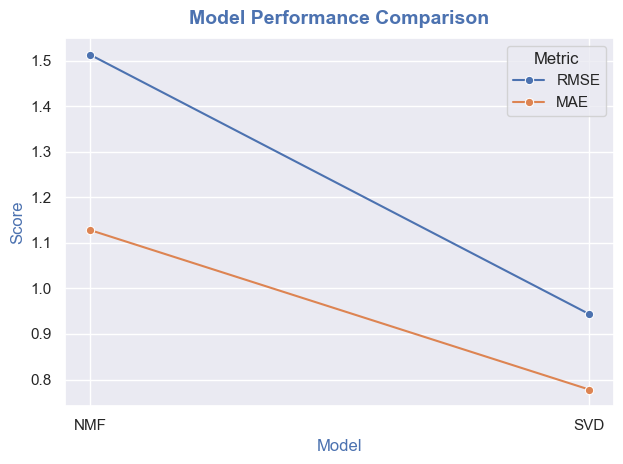

In [137]:
sns.lineplot(data=results, x='Model', y='Score', hue='Metric', marker='o')
plt.title('Model Performance Comparison', 
          size=14, 
          fontweight='bold', 
          color='#4c72b0', pad=10)
plt.ylabel('Score', fontsize=12, c='#4c72b0')
plt.xlabel('Model', fontsize=12, c='#4c72b0')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## <span style="color:steelblue"> Content-Based Filtering Model</span>

<em><span style="color:lightsteelblue">Prepare content-based data</span></em>

In [138]:
goodbooks_cb = goodbooks[['user_id', 'work_id', 'title', 'scaled_desc_emb']]

In [139]:
embeddings = np.array(goodbooks_cb['scaled_desc_emb'].tolist()).astype(np.float32)

<em><span style="color:lightsteelblue">Create HNSW (Heirarchical Navigable Small Worlds) index</span></em>

In [140]:
dim = embeddings.shape[1]
num_entries = embeddings.shape[0]

In [141]:
hnsw_index = hnswlib.Index(space='cosine', dim=dim)
hnsw_index.init_index(max_elements=num_entries, ef_construction=300, M=32)

<em><span style="color:lightsteelblue">Add entries to HNSW index</span></em>

In [142]:
hnsw_index.add_items(embeddings, ids=np.arange(num_entries))

In [143]:
hnsw_index.set_ef(80)

<em><span style="color:lightsteelblue">Generate predictions (Example)</span></em>

In [144]:
work_id = 466
k=10000
book_index = goodbooks_cb.index[goodbooks_cb['work_id'] == work_id].tolist()[0]
query_embedding = embeddings[book_index].reshape(1, -1)
labels, distances = hnsw_index.knn_query(query_embedding, k=k)

In [145]:
# print(labels)

In [146]:
predictions = goodbooks_cb.iloc[labels[0]]
predictions = predictions[predictions['work_id'] != work_id]
predictions = predictions.drop_duplicates(subset='work_id')[['work_id', 'title']][:k]

In [147]:
# print(predictions)

In [148]:
predictions['similarity'] = 1 - distances[0][:len(predictions)]

In [149]:
user_id = 45551
user_ratings = goodbooks_cf[goodbooks_cf['user_id'] == user_id]
user_ratings = user_ratings.reset_index()

In [150]:
predictions = predictions.merge(user_ratings[['work_id', 'rating']], on='work_id', how='left')

In [151]:
predictions['rating'] = predictions['rating'].fillna(0)

In [152]:
features = predictions[['similarity', 'rating']].values
labels = predictions['rating'].values

#### <em><span style="color:steelblue">Using linear regression</span></em>

In [153]:
lr = LinearRegression()
lr.fit(features, labels)

LinearRegression()

In [154]:
lr_predicted_ratings = lr.predict(features)

In [155]:
lr_rmse = np.sqrt(mean_squared_error(labels, lr_predicted_ratings))
lr_mae = mean_absolute_error(labels, lr_predicted_ratings)
lr_r2 = r2_score(labels, lr_predicted_ratings)

<em><span style="color:lightsteelblue"> Evaluate LR model</span></em>

In [156]:
print("RMSE:", lr_rmse)
print("MAE:", lr_mae)
print("R²:", lr_r2)

RMSE: 7.69804528953124e-17
MAE: 4.883373607433146e-18
R²: 1.0


#### <em><span style="color:steelblue">Using random forest regressor</span></em>

In [157]:
rf = RandomForestRegressor(max_depth=None, min_samples_leaf=1,
                           min_samples_split=2, n_estimators=50,
                           random_state=42)
rf.fit(features, labels)

RandomForestRegressor(n_estimators=50, random_state=42)

<em><span style="color:lightsteelblue"> GridSearchCV</span></em>

In [158]:
# rf_params = {
#     'n_estimators': [50, 100, 200], 
#     'max_depth': [None, 10, 20, 30],  
#     'min_samples_split': [2, 5, 10], 
#     'min_samples_leaf': [1, 2, 4]
# }

In [159]:
# rf_gs = skGridSearchCV(rf, rf_params, scoring='neg_mean_squared_error')
# rf_gs.fit(features, labels)

In [160]:
# print("Best parameters:", rf_gs.best_params_)
# print("Best RMSE: ", np.sqrt(-rf_gs.best_score_))

In [161]:
rf_predicted_ratings = rf.predict(features)

In [162]:
rf_rmse = np.sqrt(mean_squared_error(labels, rf_predicted_ratings))
rf_mae = mean_absolute_error(labels, rf_predicted_ratings)
rf_r2 = r2_score(labels, rf_predicted_ratings)

<em><span style="color:lightsteelblue"> Evaluate RF model</span></em>

In [163]:
print("RMSE:", rf_rmse)
print("MAE:", rf_mae)
print("R²:", rf_r2)

RMSE: 0.03921083535593265
MAE: 0.0011305070656691604
R²: 0.8843038269550749


#### <em><span style="color:steelblue">Model Comparison</span></em>

In [164]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Linear Regression', 'Linear Regression', 
              'Random Forest', 'Random Forest', 'Random Forest'],
    'Metric': ['RMSE', 'MAE', 'R²', 'RMSE', 'MAE', 'R²'],
    'Score': [lr_rmse, lr_mae, lr_r2, rf_rmse, rf_mae, rf_r2]
})

In [165]:
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

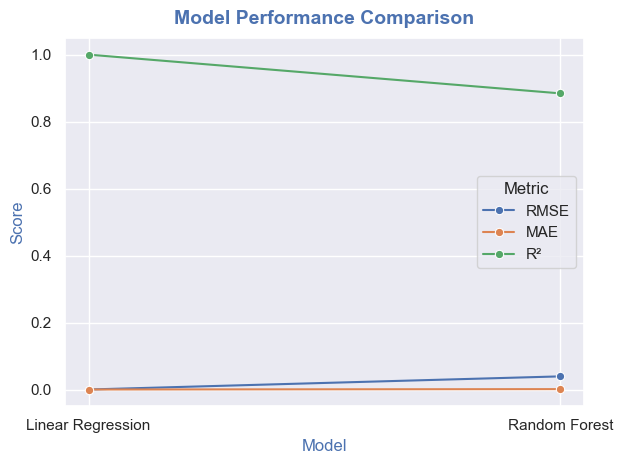

In [180]:
sns.lineplot(data=results, x='Model', y='Score', hue='Metric', marker='o')
plt.title('Model Performance Comparison', 
          size=14, 
          fontweight='bold', 
          color='#4c72b0', pad=10)
plt.ylabel('Score', fontsize=12, c='#4c72b0')
plt.xlabel('Model', fontsize=12, c='#4c72b0')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## <span style="color:steelblue"> Hybrid Recommendation System</span>

<em><span style="color:lightsteelblue">CF Recommendation Function</span></em>

In [167]:
# def get_cf_data():
#     conn = sqlite3.connect('bookscout.db')
#     ratings_df = pd.read_sql_query('SELECT * FROM ratings', conn)
#     conn.close()
    
#     return ratings_df

In [168]:
# def prepare_cf_data(ratings_df):
#     reader = Reader(rating_scale=(1, 5))
#     data = Dataset.load_from_df(ratings_df[['user_id', 'work_id', 'rating']], reader)
    
#     return data

In [169]:
# def load_svd():
#     try:
#         with open('svd.pkl', 'rb') as f:
#             return pickle.load(f)
#     except FileNotFoundError:
#         return None

In [170]:
# def train_svd(data):
#     svd = load_svd()
#     if svd:
#         return svd
    
#     trainset, testset = train_test_split(data, test_size=0.25)
#     svd = SVD(n_factors=150, n_epochs=40, lr_all=0.011, reg_all=0.006)
#     svd.fit(trainset)
    
#     with open('svd.pkl', 'wb') as f:
#         pickle.dump(svd, f)

#     return svd

In [171]:
# def get_cf_recommendations(user_id):
#     ratings_df = get_cf_data()
#     data = prepare_cf_data(ratings_df)
#     model = train_svd(data)
    
#     all_books = ratings_df['work_id'].unique()
#     rated_books = ratings_df[(ratings_df['user_id'] == user_id) & (ratings_df['rating'] > 0)]['work_id']
#     predictions = []
    
#     for book in all_books:
#         if book not in rated_books:
#             pred = model.predict(user_id, book)
#             predictions.append((book, pred.est))
    
#     predictions.sort(key=lambda x: x[1], reverse=True)
#     top_cf_recommendations = predictions[:5]
#     return top_cf_recommendations

<em><span style="color:lightsteelblue">CB Recommendation Function</span></em>

In [172]:
# def get_cb_data():
#     conn = sqlite3.connect('bookscout.db')
#     books_df = pd.read_sql_query('SELECT work_id, title, desc_emb, image_url FROM books', conn)
#     conn.close()
    
#     return books_df

In [173]:
# def load_embeddings(books_df):
#     embeddings_float = []

#     for embedding_bytes in books_df['desc_emb']:
#         if embedding_bytes is not None:
#             try:
#                 emb = np.frombuffer(embedding_bytes, dtype=np.float32)
#                 embeddings_float.append(emb)
#             except Exception as e:
#                 print(f"Error converting bytes to array: {e}")
#                 embeddings_float.append(None)
#         else:
#             embeddings_float.append(None)

#     embeddings_float = [emb for emb in embeddings_float if emb is not None]
    
#     if not embeddings_float:
#         raise ValueError("No valid embeddings found.")
    
#     return np.array(embeddings_float, dtype=np.float32)

In [174]:
# def get_cb_recommendations(work_id, k=10):
#     books_df = get_cb_data()
#     embeddings_float = load_embeddings(books_df)
    
#     if embeddings_float.size == 0:
#         raise ValueError("No valid embeddings found.")
    
#     dim = embeddings_float.shape[1]
#     num_entries = embeddings_float.shape[0]
#     hnsw_index = hnswlib.Index(space='cosine', dim=dim)
#     hnsw_index.init_index(max_elements=num_entries, ef_construction=300, M=32)
#     hnsw_index.add_items(embeddings_float, ids=np.arange(num_entries))
#     hnsw_index.set_ef(300)

#     book_index = books_df[books_df['work_id'] == work_id].index

#     if book_index.size == 0:
#         raise ValueError("No valid book index found.")

#     # Use book_index[0] to get the scalar index
#     query_embedding = embeddings_float[book_index[0]].reshape(1, -1)

#     labels, distances = hnsw_index.knn_query(query_embedding, k=k)

#     # Check for valid labels
#     valid_labels = [label for label in labels[0] if label < len(books_df)]
    
#     if not valid_labels:
#         print("No valid recommendations found.")
#         return []

#     top_cb_recommendations = books_df.iloc[valid_labels][['work_id', 'title']]
#     top_cb_recommendations = top_cb_recommendations[top_cb_recommendations['work_id'] != work_id]
#     top_cb_recommendations = top_cb_recommendations.drop_duplicates(subset='work_id')[['work_id', 'title']][:5]

#     return top_cb_recommendations

<em><span style="color:lightsteelblue">Hybrid Recommendation Function</span></em>

In [175]:
# def get_hy_recommendations(user_id, work_id, cf_weight=0.5, cb_weight=0.5):
#     cf_recommendations = get_cf_recommendations(user_id)
#     cf_df = pd.DataFrame(cf_recommendations, columns=['work_id', 'predicted_rating'])
    
#     cb_recommendations = get_cb_recommendations(work_id)
#     cb_df = cb_recommendations.copy()
#     cb_df['predicted_rating'] = 1.0
    
#     hy_recommendations = pd.concat([cf_df.rename(columns={'predicted_rating': 'cf_rating'}),
#                                  cb_df.rename(columns={'predicted_rating': 'cb_rating'})],
#                                  ignore_index=True)
#     hy_recommendations = hy_recommendations.groupby('work_id').agg({'cf_rating': 'sum', 'cb_rating': 'sum'}).reset_index()
#     hy_recommendations['final_rating'] = (hy_recommendations['cf_rating'] * cf_weight) + (hy_recommendations['cb_rating'] * cb_weight)
    
#     top_hy_recommendations = hy_recommendations.sort_values(by='final_rating', ascending=False).head(5)
#     books_df = get_cb_data()
#     final_recommendations = top_hy_recommendations.merge(books_df[['work_id', 'title', 'image_url']], on='work_id', how='left')
    
#     return final_recommendations[['work_id', 'title', 'image_url']]

<em><span style="color:lightsteelblue">Generate recommendations (Example)</span></em>

In [176]:
# reset_database()
# setup_database()
# insert_books_from_df(goodbooks)
# insert_users_from_df(goodbooks)
# insert_ratings_from_df(goodbooks)

In [177]:
# user_id = 1
# work_id = 466
# recommendations = get_hy_recommendations(user_id, work_id)
# print(recommendations)